# Match Kitti Sequence version 22-11

Reads a sequence of stereo images as Frame. The Frames are scanned to identify FramePoints that are pixels that are at the top or botrom of vertical lines in the image. A patch is taken around each of the FramePoints in the left hand image, to match these to a patch in the right hand image and estimate the disparity/distance of the framePoint.

A Sequence is created in which the first Frame is the KeyFrame. It's initial FramePoints are culled to keep only the points for which there is a confident estimate of its depth. The consecutive frames are used to track the KeyFrame's remaining FramePoints. Only a limited number of all framePoints will be found in the consecutive frames, mostly because nearby objects become larger quickly as we get closer. The matching FramePoints are given the same FramePointId as the corresponding point in the KeyFrame and its depth is estimated.

The results are dumped into a folder 'dump', containing files 0.txt, 1.txt, etc. 0.txt contains the FramePoints as observed from the first frame, 1.txt form the second frame, etc. In these files, each row contains a single FramePoint with the values FramePointID, X, Y, Depth.

In [1]:
# when you change a setting you have to restart the kernel (settings are only loaded once)
import os
#os.environ['STEREO_CONFIDENCE'] = '1.6'
#os.environ['SEQUENCE_CONFIDENCE'] = '1.6'
#os.environ['PATCH_SIZE'] = '17'

import sys
sys.path.append('..')
from src.zed import *
%matplotlib inline
import numpy as np
import glob

Read the frames for KITTI sequence 00.

In [2]:
%%time
LEFTDIR = '/data/urbinn/datasets/kitti/KITTI_Left_Images/testing/image_2'
RIGHTDIR = '/data/urbinn/datasets/kitti/KITTI_Right_Images/testing/image_3/'

frame = []
for filename in sorted(glob.glob(LEFTDIR + '/*')):
    left_frame = Frame(filename, RIGHTDIR)
    frame.append(left_frame)

CPU times: user 27.9 ms, sys: 7.58 ms, total: 35.5 ms
Wall time: 34.7 ms


In [3]:
frame[0]._filepath
frame[1].get_right_frame()._filepath

'/data/urbinn/datasets/kitti/KITTI_Right_Images/testing/image_3//000001.png'

Turn the list of frames into a sequence. The first frame is automatically taken as the KeyFrame and its FramePoints are rerieved, depth is estimated, only the most confident points are kept, and they are tracked in the other frames.

In [4]:
seq = Sequence()
for f in ProgressBar()(frame[::120]):
    print(f._filepath)
    seq.add_frame(f)

N/A% (0 of 63) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

/data/urbinn/datasets/kitti/KITTI_Left_Images/testing/image_2/000000.png


  1% (1 of 63) |                          | Elapsed Time: 0:00:09 ETA:  0:09:21

/data/urbinn/datasets/kitti/KITTI_Left_Images/testing/image_2/000119.png


IndexError: pop from empty list

Inspect the FramePoints for the first frame

In [ ]:
show(draw_frame(frame[1]))

btw seq.keyframes[0] is the same as frame[0]

In [8]:
seq.keyframes[0] == frame[0]

True

To the keyframes we add the non-keyframes in their .frames property. Thus frame[1] is added as the first non keyframe after keyframes[0].

In [9]:
seq.keyframes[0].frames[0] == frame[1]

IndexError: list index out of range

We can use show2 to display two frames side-by-side. Every left frame can load it's corresponding right frame and you can request to return it using get_right_frame(). By default, right frames are not loaded unless needed, which is the case for keyframes to compute the depth of points.

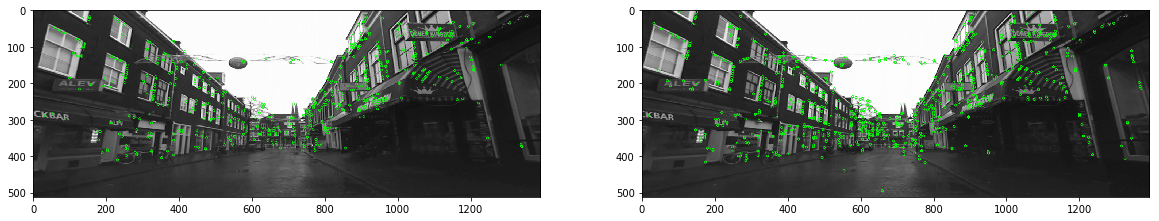

In [10]:
show2(draw_frame(seq.keyframes[0]), draw_frame(seq.keyframes[0].get_right_frame()))

You can also show the computed depth of observations. draw_frame_depth does not compute the depth but does show it if it has been computed. Alternatively you can use draw_observations() and draw_observations_depth() to show an image with a list of observations. This only makes sense if all observations belong to the same image. draw_frame_id() and draw_observations_id() show observations with their internal mappoint id to compare id's between images (did it map the same points).

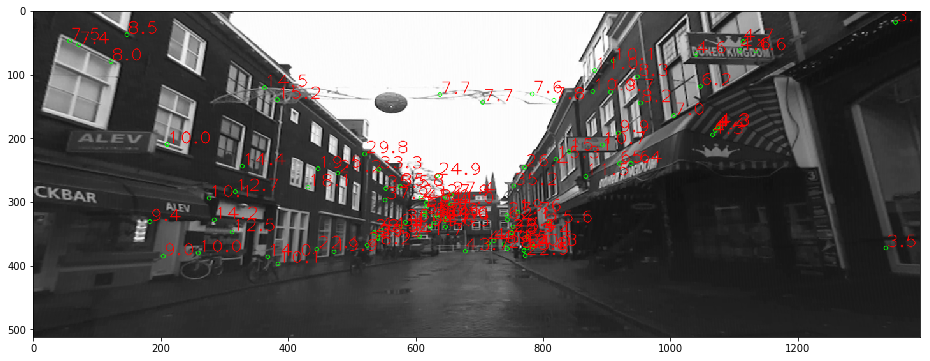

In [11]:
frame[0].compute_depth()
frame[0].filter_not_useful()
show(draw_observations_depth(frame[0].get_observations()[-100:]))

We can also manually compute the Depth of the points and show these

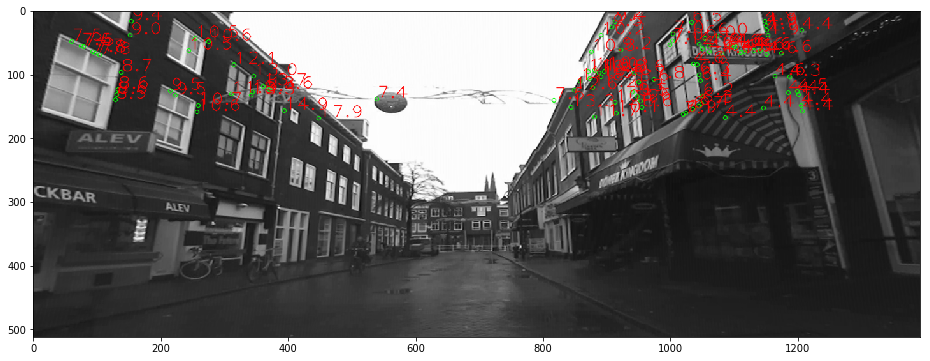

In [12]:
frame[1].compute_depth()
# filter out points that have no confident depth estimation and no binding to a mappoint
frame[1].filter_not_useful()
show(draw_observations_depth(frame[1].get_observations()[:100]))

In [13]:
cv_keyframes = get_covisible_keyframes(seq.keyframes[2])
mappoints = get_mappoints(cv_keyframes)
f_keyframes = get_fixed_keyframes(mappoints, cv_keyframes)

cv_keyframes_np = keyframes_to_np(cv_keyframes)
f_keyframes_np = keyframes_to_np(f_keyframes)
mappoints_np = mappoints_to_np(mappoints)
links_np = links_to_np(mappoints)

np.save('cv_keyframes', cv_keyframes_np)
np.save('f_keyframes', f_keyframes_np)
np.save('mappoints', mappoints_np)
np.save('links', links_np)